In [6]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

mu = pd.read_json('../Results/processed/mean_returns.json', typ='series')
cov = pd.read_csv('../Results/processed/cov_matrix.csv', index_col=0)
tickers = pd.read_csv('../Results/processed/tickers.txt', header=None)[0].tolist()

mu_vec = mu.loc[tickers].values
Sigma = cov.loc[tickers, tickers].values + 1e-8 * np.eye(len(tickers))

# Optimization
lam = 10
x = cp.Variable(len(tickers))
objective = cp.Minimize(cp.quad_form(x, Sigma) - lam * (mu_vec @ x))
constraints = [cp.sum(x) == 1, x >= 0, x <= 0.3]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP)

weights = x.value
portfolio_return = float(mu_vec @ weights)
portfolio_risk = float(np.sqrt(weights @ Sigma @ weights))
top_n = 5

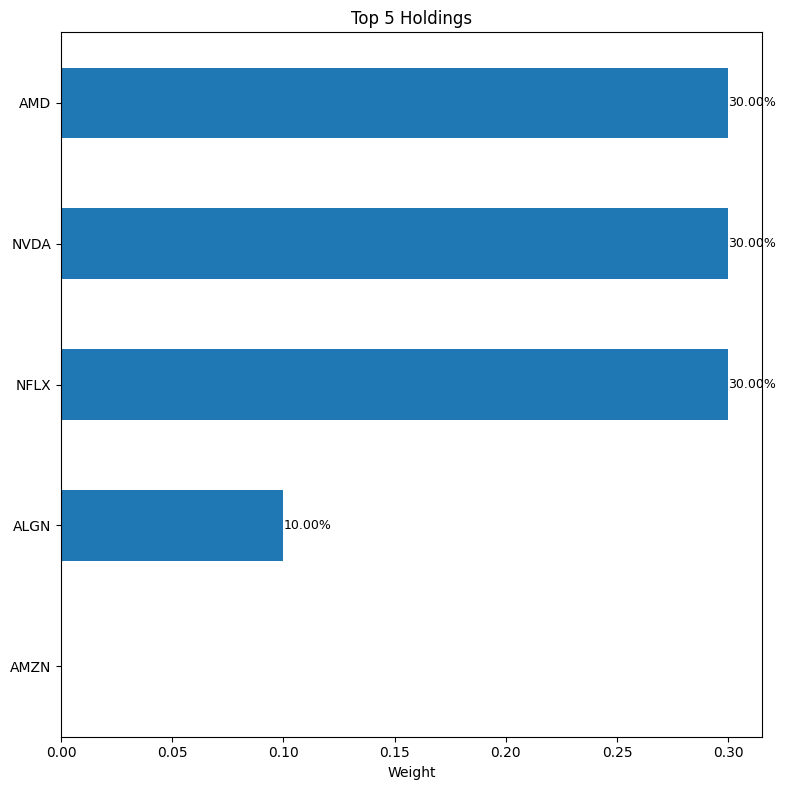

,weight
NVDA,3.000000e-01
NFLX,3.000000e-01
AMD,3.000000e-01
ALGN,1.000000e-01
AMZN,5.920015e-21



Top 5 cover 100.00% of total weight.
Tickers to reach 80% cumulative weight: 3


In [7]:
import math
if 'weights' not in globals() or weights is None:
    print('No `weights` found. Run the optimization cell first.')
else:
    w = pd.Series(np.asarray(weights).flatten(), index=tickers).fillna(0)
    w_desc = w.sort_values(ascending=False)
    top = w_desc.head(top_n)
    others_sum = w_desc.iloc[top_n:].sum()

    # Prepare plot series: top N and an 'Others' aggregate if applicable
    plot_series = top.copy()
    if abs(others_sum) > 1e-12:
        plot_series['Others'] = others_sum

    # Horizontal bar plot with decent spacing and font sizes
    n_bars = len(plot_series)
    plt.figure(figsize=(8, 1.2 * n_bars + 2))
    ax = plt.gca()
    plot_series_plot = plot_series.sort_values(ascending=True)
    colors = ['#1f77b4' if lbl != 'Others' else '#7f7f7f' for lbl in plot_series_plot.index]
    plot_series_plot.plot(kind='barh', color=colors, ax=ax)

    # Annotate values on bars
    for i, (label, val) in enumerate(plot_series_plot.items()):
        if abs(val) > 1e-6:
            ax.text(val + 1e-6, i, f'{val:.2%}', va='center', fontsize=9)

    ax.set_xlabel('Weight')
    ax.set_title(f'Top {top_n} Holdings')
    # Improve y-axis label readability
    ax.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.show()

    # Display the top contributors)
    try:
        display(plot_series.to_frame('weight'))
    except NameError:
        print(plot_series.to_string(formatter=lambda x: f'{x:.4f}'))

    # Print concentration information
    cum = w.sort_values(ascending=False).cumsum()
    pct_top = cum.iloc[top_n-1] if len(cum) >= top_n else cum.iloc[-1] if len(cum)>0 else 0
    print(f"\nTop {top_n} cover {pct_top:.2%} of total weight.")
    try:
        idx = int(np.searchsorted(cum.values, 0.8))
        n_needed = min(idx + 1, len(cum))
    except Exception:
        n_needed = None
    if n_needed:
        print(f"Tickers to reach 80% cumulative weight: {n_needed}")

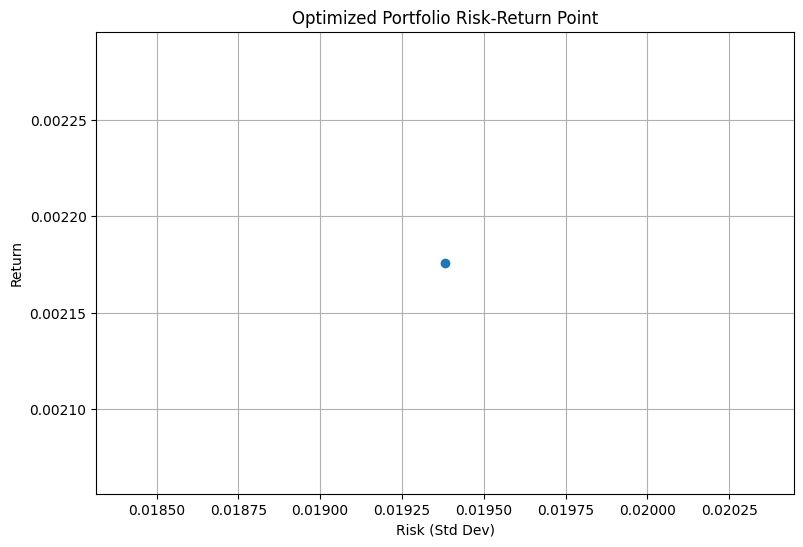

In [8]:
plt.figure(figsize=(9,6))
plt.scatter([portfolio_risk], [portfolio_return])
plt.xlabel('Risk (Std Dev)')
plt.ylabel('Return')
plt.title('Optimized Portfolio Risk-Return Point')
plt.grid(True)
plt.show()

In [9]:
import json
import os

info = {
    "portfolio_return": portfolio_return,
    "portfolio_risk": portfolio_risk,
    "sharpe_ratio": portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
}

os.makedirs("../Results/optimized_portfolios", exist_ok=True)
result_data = {
    "weights": weights.tolist() if hasattr(weights, 'tolist') else list(weights),
    "portfolio_return": info['portfolio_return'],
    "portfolio_risk": info['portfolio_risk'],
    "sharpe_ratio": info['sharpe_ratio'],
    "description": "Original Convex Model"
}

with open("../Results/optimized_portfolios/convex_solution.json", "w") as f:
    json.dump(result_data, f, indent=4)

print("[SUCCESS] Saved convex_solution.json for final comparison.")

[SUCCESS] Saved convex_solution.json for final comparison.


Plots will be displayed in the notebook.
--- Running Convexity Checks ---


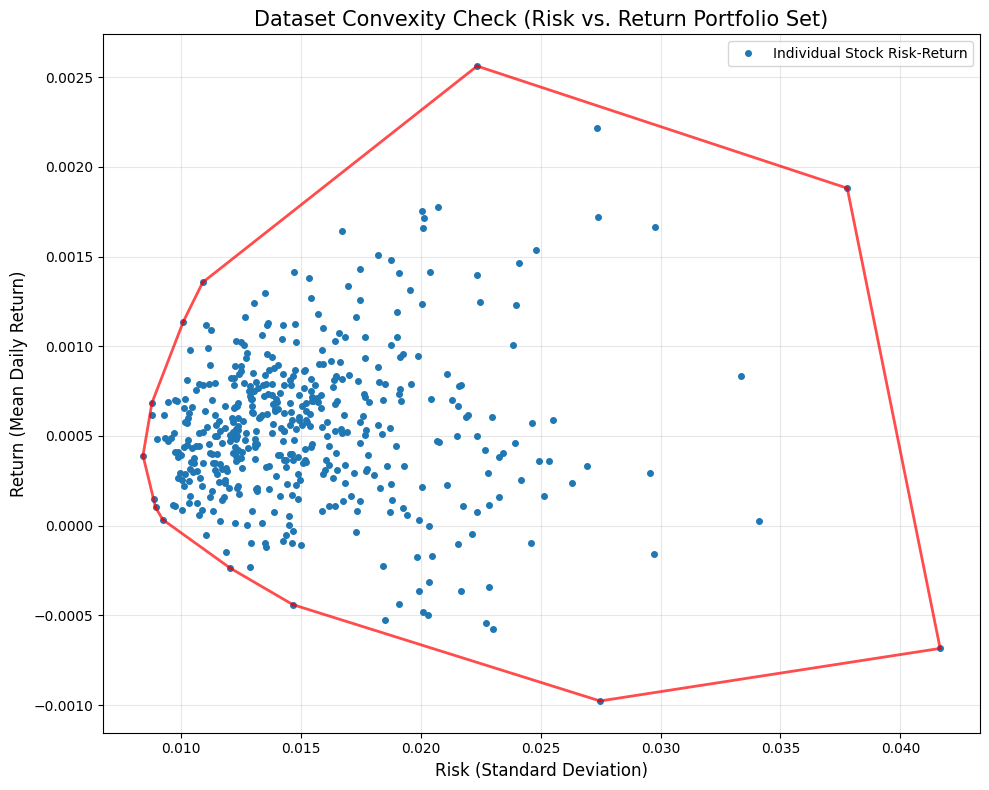

[SUCCESS] Dataset Convexity Check Complete.


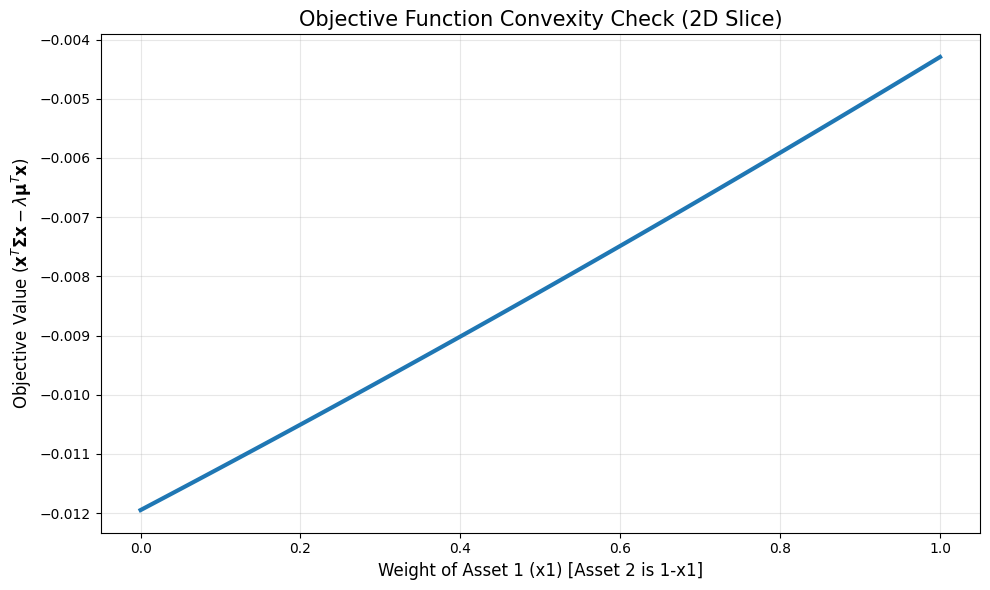

[SUCCESS] Objective Function Convexity Check Complete.

All required convexity plots have been generated and displayed.


In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull 
import cvxpy as cp 

print("Plots will be displayed in the notebook.")
print("=" * 70)

# --- Define Plotting Functions Locally to Guarantee Consistency ---

def plot_convex_hull(mu, Sigma, tickers):
    # 1. Prepare data for plotting
    risk = np.sqrt(np.diag(Sigma))
    data_df = pd.DataFrame({
        'return': mu,
        'risk': risk
    }, index=tickers)

    points = data_df[['risk', 'return']].values

    if points.shape[0] < 3:
        print("[SKIP] Cannot plot convex hull: Need at least 3 assets.")
        return

    # 2. Compute the convex hull
    hull = ConvexHull(points) 

    # 3. Plotting
    plt.figure(figsize=(10, 8))
    plt.plot(points[:, 0], points[:, 1], 'o', markersize=4, label='Individual Stock Risk-Return')

    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=2, alpha=0.7) 

    plt.title('Dataset Convexity Check (Risk vs. Return Portfolio Set)', fontsize=15)
    plt.xlabel('Risk (Standard Deviation)', fontsize=12)
    plt.ylabel('Return (Mean Daily Return)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() 
    plt.close()
    print(f"[SUCCESS] Dataset Convexity Check Complete.")


def plot_objective_function(Sigma, mu_vec, lam):
    n = len(mu_vec)
    if n < 2:
        print("[SKIP] Cannot plot objective function: Need at least 2 assets.")
        return

    # Use only the first two assets for a 2D slice (x1 + x2 = 1, x3...xn = 0)
    Sigma_2 = Sigma[:2, :2]
    mu_vec_2 = mu_vec[:2]

    x1_range = np.linspace(0, 1, 100)
    obj_values = []
    
    for x1 in x1_range:
        x2 = 1.0 - x1
        x = np.array([x1, x2])

        risk_term = x.T @ Sigma_2 @ x
        return_term = lam * (mu_vec_2 @ x)
        obj = risk_term - return_term
        obj_values.append(obj)

    plt.figure(figsize=(10, 6))
    plt.plot(x1_range, obj_values, linewidth=3)

    plt.title('Objective Function Convexity Check (2D Slice)', fontsize=15)
    plt.xlabel(f'Weight of Asset 1 (x1) [Asset 2 is 1-x1]', fontsize=12)
    plt.ylabel(r'Objective Value ($\mathbf{x}^T \mathbf{\Sigma} \mathbf{x} - \lambda \mathbf{\mu}^T \mathbf{x}$)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show() 
    plt.close()
    print(f"[SUCCESS] Objective Function Convexity Check Complete.")


print("--- Running Convexity Checks ---")
# Plot 1: Dataset Convexity (Convex Hull)
plot_convex_hull(
    mu=mu_vec, 
    Sigma=Sigma, 
    tickers=tickers, 
)

# Plot 2: Objective Function Convexity (2D Slice)
plot_objective_function(
    Sigma=Sigma, 
    mu_vec=mu_vec, 
    lam=lam, 
)

print("\nAll required convexity plots have been generated and displayed.")